# Lab 5: Image segmentation and compression

Adele Younis (20944650) and Meg Paulson (21038856)

In [83]:
from skimage.color import rgb2ycbcr, rgb2lab, rgb2gray
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

from scipy.fftpack import dct
from skimage.metrics import peak_signal_noise_ratio as PSNR

In [84]:
# read in images 
f = rgb2gray(imread('lena.jpg'))

In [85]:
def sub2ind(n_row, row, col):
  return n_row * col + row

def dctmtx(N):
  return dct(np.eye(N), norm='ortho', axis=0)

def func(x, mat):
  return mat @ x @ mat.T

def func1(x, mat):
  return np.multiply(mat, x)

def blockproc(im, mat, block_sz, func):
    h, w = im.shape
    m, n = block_sz
    im_out = np.zeros_like(im)
    for x in range(0, h, m):
        for y in range(0, w, n):
            block = im[x:x+m, y:y+n]
            im_out[x:x+m, y:y+n] = func(block, mat)
    return im_out

Part 3: Image Transform

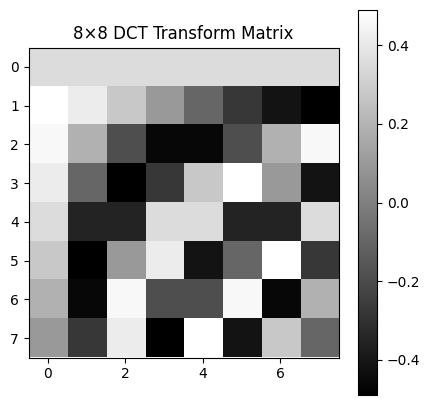

In [86]:
T = dctmtx(8) # 8x8 DCT transform matrix T

plt.figure(figsize=(5,5))
plt.imshow(T, cmap='gray')
plt.title("8×8 DCT Transform Matrix")
plt.colorbar()
plt.show()


10. What does each row of the DCT transform matrix represent? Look at the pattern for each row. If
you still don’t see it, try plotting each of the rows as a 1-D function.


Each row within the DCT matrix is a cosine of increasing frequency. Row 0 specifically is the DC gain, which is why it looks like it is just an average around the lightest shade (0.4), since cosine is at it's max amplitude at 0. The remaining rows, rows 1 -7, are all cosine waves that oscillate at increasing frequencies. For example row 1 only goes through all the colours once, indicating it oscillates only once across the 8 pixels. On the other hand, row 2 apears to have 2 oscillations, identified by the bright to dark to bright pattern. The remaining rows all follow this pattern, with an increasing number of oscillations each time, meaniing thats the cosine waves frequency is increasing. 

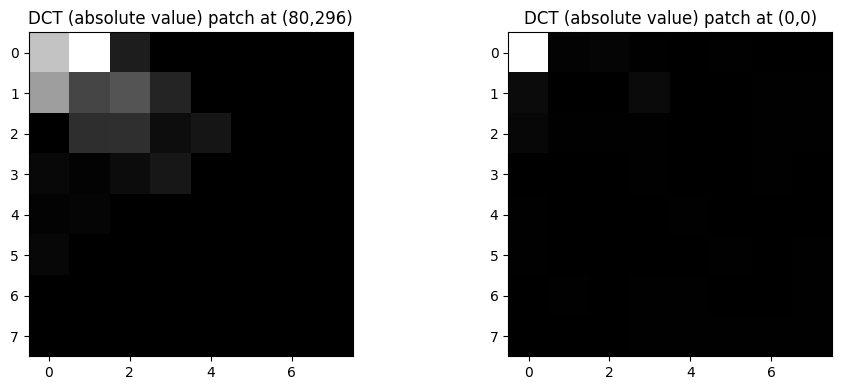

In [87]:
F_trans = np.floor(blockproc((f* 255) - 128, T, [8, 8], func))

# Patch 1: top-left at (80,296)
r1, c1 = 80, 296
patch1 = F_trans[r1:r1+8, c1:c1+8]

# Patch 2: top-left at (0,0)
patch2 = F_trans[0:8, 0:8]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(np.abs(patch1), cmap='gray')
plt.title("DCT (absolute value) patch at (80,296)")

plt.subplot(1,2,2)
plt.imshow(np.abs(patch2), cmap='gray')
plt.title("DCT (absolute value) patch at (0,0)")

plt.tight_layout()
plt.show()

11. Describe the energy distribution of the DCT of the sub-images. What does each pixel represent? Explain why DCT would be useful for image compression in the context of the DCT energy distribution.

Each pixel within the DCT block represents the strength of a specific spatial frequency, with the top left representing the low frequency range, with high frequencies increasing as you go out. The DCT patch taken at (0,0) has energy only in the top left corner, indicating that its frequency elements are mostly very low. On the other hand, the DCT patch taken at (80,296) has more spread out frequencies, although it is still mostly about the top left corner. This means that the frequency elements within that image are still low, but have greater variation. Since most elements within this DCT appear to be within the low frequency range, DCT shows promise for compression as it keeps only a few strong low frequencies, while omitting most high ones. 


12. Compare the DCT of the two sub-images. How are they different? Why? Explain in the context of the image characteristics at those locations and the DCT energy distribution

The patch at (80,296) in the original image has more visible structure and edges, so its DCT has stronger and more spread out pixel coefficients. The patch at (0,0) is smoother and more uniform, so its DCT has almost all energy in the DC term, with very small high-frequency coefficients.



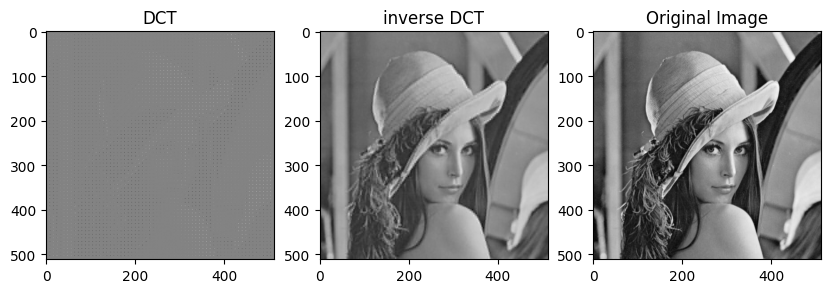

PSNR: 29.98968129978148


In [88]:
mask = np.zeros((8 ,8))
mask [0, 0] = 1
mask [0, 1] = 1
mask [0, 2] = 1
mask [1, 0] = 1
mask [1, 1] = 1
mask [2, 0] = 1

F_thresh = blockproc(F_trans, mask, [8, 8], func1)

f_thresh = np.floor(blockproc(F_thresh, T.T, [8,8], func)) + 128

plt.figure(figsize=(10,8))

plt.subplot(1,3,1)
plt.imshow(F_thresh, cmap='gray')
plt.title("DCT")

plt.subplot(1,3,2)
plt.imshow(f_thresh, cmap='gray')
plt.title("inverse DCT")

plt.subplot(1,3,3)
plt.imshow(f, cmap='gray')
plt.title("Original Image")

plt.show()

print(f"PSNR: {PSNR((f*255), f_thresh, data_range=255)}")

13. Describe how the reconstructed image looks compared to the original image.
Why does it look this way?

The reconstructed image looks very similar to the original, with only slightly less contrast. It looks this way because the inverse DCT perfectly reconstructs the image when all DCT coefficients are kept with the small differences in the high frequency components being a result of quantization.

14. What artifact is most prominent in the image? Why does this artifact appear?

The most prominent artifact within the image is the blurring at the edges. Since edges are high frequency components, and DCT compresses some of the higher frequency components, the reconstructed image is not able to retain the textures and edges as well as the original image.

15. What conclusions can you draw about the DCT in terms of image compression? Does it work
well? If yes, why does it work well?

We can draw that that DCT works welll in images comprised mostly of low frequency information, meaning that the high frequency information within an image can be removed without deprecated the image quality significantly. 

Part 4. Quantization

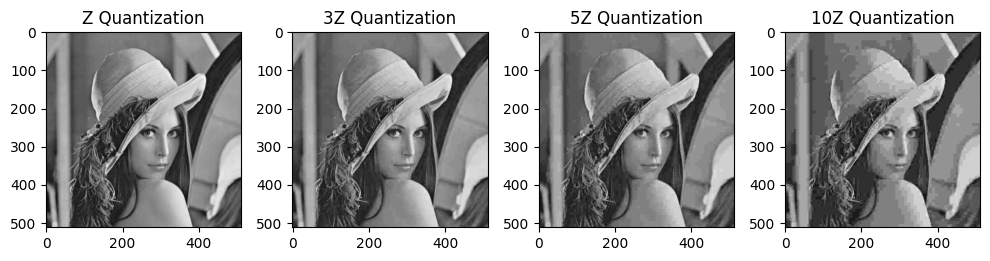

Z PSNR: 36.52333660880001
3Z PSNR: 32.55747657479149
5Z PSNR: 30.489752438881034
10Z PSNR: 27.404317725175268


In [89]:
# standard JPEG quantization matrix
Z = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

F_trans = np.floor(blockproc((f*255) - 128, T, [8, 8], func))

# Quantization
F_quant_Z   = np.round(blockproc(F_trans,    1/Z,     [8,8], func1))
F_quant_3Z  = np.round(blockproc(F_trans,    1/(3*Z), [8,8], func1))
F_quant_5Z  = np.round(blockproc(F_trans,    1/(5*Z), [8,8], func1))
F_quant_10Z = np.round(blockproc(F_trans,    1/(10*Z),[8,8], func1))

# Dequantization
F_dequant_Z   = blockproc(F_quant_Z,    Z,     [8,8], func1)
F_dequant_3Z  = blockproc(F_quant_3Z,   3*Z,   [8,8], func1)
F_dequant_5Z  = blockproc(F_quant_5Z,   5*Z,   [8,8], func1)
F_dequant_10Z = blockproc(F_quant_10Z,  10*Z,  [8,8], func1)

# Inverse DCT
rec_Z    = np.floor(blockproc(F_dequant_Z,    T.T, [8,8], func)) + 128
rec_3Z   = np.floor(blockproc(F_dequant_3Z,   T.T, [8,8], func)) + 128
rec_5Z   = np.floor(blockproc(F_dequant_5Z,   T.T, [8,8], func)) + 128
rec_10Z  = np.floor(blockproc(F_dequant_10Z,  T.T, [8,8], func)) + 128

# Clip values
rec_Z    = np.clip(rec_Z,    0,255)
rec_3Z   = np.clip(rec_3Z,   0,255)
rec_5Z   = np.clip(rec_5Z,   0,255)
rec_10Z  = np.clip(rec_10Z,  0,255)

plt.figure(figsize=(10,4))

plt.subplot(1,4,1)
plt.imshow(rec_Z, cmap='gray')
plt.title("Z Quantization")

plt.subplot(1,4,2)
plt.imshow(rec_3Z, cmap='gray')
plt.title("3Z Quantization")

plt.subplot(1,4,3)
plt.imshow(rec_5Z, cmap='gray')
plt.title("5Z Quantization")

plt.subplot(1,4,4)
plt.imshow(rec_10Z, cmap='gray')
plt.title("10Z Quantization")

plt.tight_layout()
plt.show()

print(f"Z PSNR: {PSNR((f*255), rec_Z, data_range=255)}")
print(f"3Z PSNR: {PSNR((f*255), rec_3Z, data_range=255)}")
print(f"5Z PSNR: {PSNR((f*255), rec_5Z, data_range=255)}")
print(f"10Z PSNR: {PSNR((f*255), rec_10Z, data_range=255)}")


16. What happens to the DCT coefficients when quantization is performed? What effect does it have
on image quality?

Quantization divides the DCT coefficients by a weight, which in turn pushes many of the high frequency components to approach 0. This results in the image quality decreasing, as the image appears blurrier and final details are no longer preserved. 

17. Compare the reconstructed image produced using 3Z with the original image. Why does the
reconstructed image look this way?

Comparing the 3Z reconstruction image with the original image shows that the reconstructed image is more blocky and grainy, in addition to the blurring artifacts mentioned before. The reconstructed image looks this way since it is more aggressively quantizing, meaning more high frequency information are lost, leading to more visible block boundaries. 

18. Compare the reconstructed images produced by the different levels of quantization, as well as the
PSNR for each reconstructed image. What happens as the level of quantization increases?

As the quantization level increases, the PSNR decreases and the reconstructed images appear more blurred and blocky. All around, the higher quanitzation leads to a more distorted reconstruction image, since more DCT coefficients are approaching 0. 

19. Which artifact becomes more prominent as the level of quantization increases? Why?

The 8x8 blocking artifact becomes more prominent as the level of quantization increases. This is because higher quantization exaggerates the difference between neighbouring blocks once the high frequency components are altered. 

20. What conclusions can you draw about the quantization process? Explain in the context of the trade-
off between compression performance and image quality.

From this section in the lab, we can conclude that the quantization process can greatly decrease the file size required to best represent an image, and more specifically the underlying image structure. However, stronger quantization gives higher compression at the cost of more blocking, blurring, and lower PSNR. This concludes thar DCT quantization is a balance between file size and image quality.

**Conclusion**

This lab explores image segmentation and image compression. The first part of the lab uses the Segment Anything Model (SAM) to segment images in two ways - automatic mask generation, and prompt-based mask generation. Both methods were performed to better understand how bounding boxes might affect the masking and segmentation of specific image components. The second part of the lab explored image compression, primarily through discrete cosing transformation (DCT) and quantization. This lab revealed that most of an images information can be preserved with just the low frequency components, as done so within DCT reconstruction. Quantization of the DCT coefficients was also explored and revealed that quanitzation balances image file size and image quality.